In [31]:
%matplotlib inline

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

In [2]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import shutil
import imageio
import matplotlib.pyplot as plt
import re
from PIL import Image

## 1. Load and split image data

#### MADOS to RGB and Mask

In [3]:
## get file from the file list (train.txt, test.txt, val.txt)
flist_path = '../MADOS/splits'
### MADOS file structure
## Scene_??_
data_path = "../MADOS"

path = ''
image_path = os.path.join(path, '../data/CameraRGB/')
label_path = os.path.join(path, '../data/CameraMask/')

In [4]:
image_list_orig = os.listdir(image_path)
image_list = [image_path+i for i in image_list_orig]
mask_list_orig = os.listdir(label_path)
mask_list = [label_path+i for i in mask_list_orig]

In [5]:
len(image_list), len(mask_list)

(2075, 2075)

In [6]:
image_list[0]

'../data/CameraRGB/Scene_0_L2R_rgb_1.png'

In [7]:
def splitDataset():
    image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
    mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

    for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
        print(path)
        
    image_filenames = tf.constant(image_list)
    masks_filenames = tf.constant(mask_list)
    dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

    for image, mask in dataset.take(1):
        print(image)
        print(mask)
        
    return dataset

In [8]:
dataset = splitDataset()

(<tf.Tensor: shape=(), dtype=string, numpy=b'..\\data\\CameraRGB\\Scene_0_L2R_rgb_1.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'..\\data\\CameraMask\\Scene_0_L2R_cl_1.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'..\\data\\CameraRGB\\Scene_0_L2R_rgb_2.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'..\\data\\CameraMask\\Scene_0_L2R_cl_2.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'..\\data\\CameraRGB\\Scene_0_L2R_rgb_3.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'..\\data\\CameraMask\\Scene_0_L2R_cl_3.png'>)
tf.Tensor(b'../data/CameraRGB/Scene_0_L2R_rgb_1.png', shape=(), dtype=string)
tf.Tensor(b'../data/CameraMask/Scene_0_L2R_cl_1.png', shape=(), dtype=string)


In [8]:
len(dataset)

2075

#### 1.2 - Preprosess the Data¶

In [9]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)

    return img, mask

# resize
def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')

    return input_image, input_mask

In [10]:
image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

In [11]:
class_names = ['Non-annotated',
        'Marine Debris',
        'Dense Sargassum',
        'Sparse Floating Algae',
        'Natural Organic Material',
        'Ship',
        'Oil Spill',
        'Marine Water',
        'Sediment-Laden Water',
        'Foam',
        'Turbid Water',
        'Shallow Water',
        'Waves and Wakes',
        'Oil Platform',
        'Jellyfish',
        'Sea snot']

In [12]:
EPOCHS = 5
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))


## 2. Model (U-Net)

### 2.1 Encoder
* 2 Conv, MaxPooling, and dropout

In [116]:
# conv_block
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  # set 'kernel_initializer' same as above
                  kernel_initializer='he_normal')(conv)
    
    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
        
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        next_layer = MaxPooling2D((2,2))(conv)
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

### 2.2 Decoder

In [117]:
#upsampling_block
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    
    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 3,    # Kernel size
                 strides=2,
                 padding='same')(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,   # Number of filters
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,  # Number of filters
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                  # set 'kernel_initializer' same as above
                 kernel_initializer='he_normal')(conv)
    
    return conv

### 2.3 U-Net

In [118]:
# unet_model
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    # Contracting Path (encoding)
    cblock1 = conv_block(inputs, n_filters)
    # Double the number of filters at each new step
    cblock2 = conv_block(cblock1[0], n_filters*2)
    cblock3 = conv_block(cblock2[0], n_filters*4)
    cblock4 = conv_block(cblock3[0], n_filters*8, dropout_prob=0.3) # Include a dropout_prob of 0.3 for this layer
    cblock5 = conv_block(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False) 
    
    # Expanding Path (decoding)
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  n_filters*8)
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters*4)
    ublock8 = upsampling_block(ublock7, cblock2[1],  n_filters*2)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [145]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))
unet.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_70 (Conv2D)             (None, 96, 128, 32)  896         ['input_11[0][0]']               
                                                                                                  
 conv2d_71 (Conv2D)             (None, 96, 128, 32)  9248        ['conv2d_70[0][0]']              
                                                                                                  
 max_pooling2d_15 (MaxPooling2D  (None, 48, 64, 32)  0           ['conv2d_71[0][0]']        

                                                                                                  
 conv2d_89 (Conv2D)             (None, 96, 128, 23)  759         ['conv2d_88[0][0]']              
                                                                                                  
Total params: 8,640,471
Trainable params: 8,640,471
Non-trainable params: 0
__________________________________________________________________________________________________


### 2.4 Loss function

In [166]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### 2.5 Train the Model

In [168]:
model_history = unet.fit(train_dataset, epochs=EPOCHS)

Epoch 1/5
65/65 [==============================] - 161s 2s/step - loss: 0.2911 - accuracy: 0.9710
Epoch 2/5
65/65 [==============================] - 158s 2s/step - loss: 0.0745 - accuracy: 0.9906
Epoch 3/5
65/65 [==============================] - 159s 2s/step - loss: 0.0676 - accuracy: 0.9903
Epoch 4/5
65/65 [==============================] - 159s 2s/step - loss: 0.0629 - accuracy: 0.9904
Epoch 5/5
65/65 [==============================] - 158s 2s/step - loss: 0.0622 - accuracy: 0.9901


### 2.6 Plot Model Accuracy

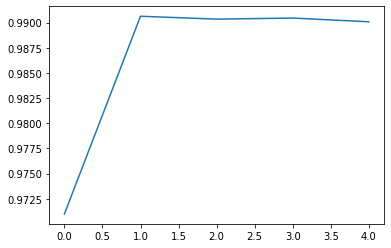

In [169]:
plt.plot(model_history.history["accuracy"])

### 2.7 Save and load model

In [178]:
# Save model
unet.save('save/model')

INFO:tensorflow:Assets written to: save/model\assets


INFO:tensorflow:Assets written to: save/model\assets


In [13]:
#load model
unet = tf.keras.models.load_model('save/model')
unet.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_70 (Conv2D)             (None, 96, 128, 32)  896         ['input_11[0][0]']               
                                                                                                  
 conv2d_71 (Conv2D)             (None, 96, 128, 32)  9248        ['conv2d_70[0][0]']              
                                                                                                  
 max_pooling2d_15 (MaxPooling2D  (None, 48, 64, 32)  0           ['conv2d_71[0][0]']        

                                                                                                  
 conv2d_89 (Conv2D)             (None, 96, 128, 23)  759         ['conv2d_88[0][0]']              
                                                                                                  
Total params: 8,640,471
Trainable params: 8,640,471
Non-trainable params: 0
__________________________________________________________________________________________________


### 2.6 Test

In [14]:
def display(display_list, class_number):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(f'{title[i]},{class_names[class_number]}')
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [15]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [24]:
def get_label(mask):
    # Count number of non-zero pixels in the mask (non-background regions)
    mask_flat = mask.flatten()
    # Calculate the histogram
    unique_values, counts = np.unique(mask_flat, return_counts=True)
    
    positive_unique_values = np.abs(unique_values).astype(int)
    # Find the index of the maximum count
    max_count_index = np.argmax(counts)

    # Get the unique value with the maximum count
    max_count_value = positive_unique_values[max_count_index]
    max_count = counts[max_count_index]
    #print('label:',max_count_value,max_count, class_name[max_count_value])#, class_name[unique_values])
    return positive_unique_values, counts

In [27]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            label_numbers, counts = get_label(pred_mask)
            print(label_numbers[0])
            display([image[0], mask[0], create_mask(pred_mask)], label_numbers[0])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 0s 469ms/step
13


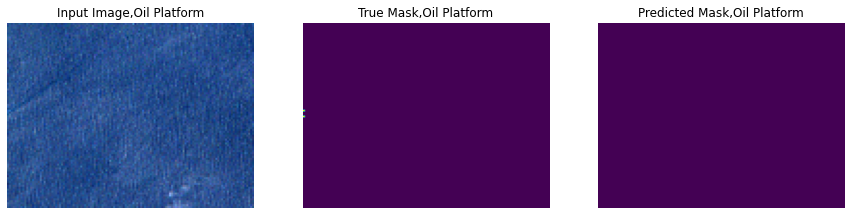

1/1 [==============================] - 0s 452ms/step
10


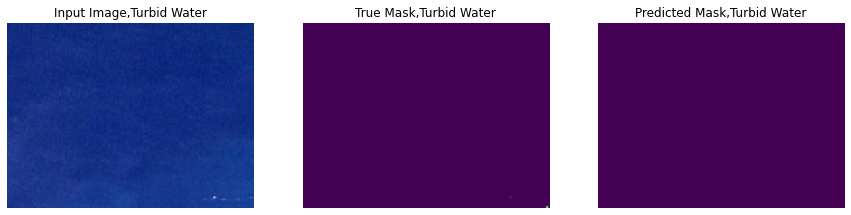

1/1 [==============================] - 0s 449ms/step
13


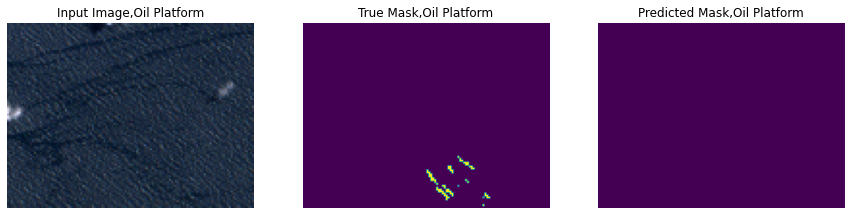

1/1 [==============================] - 0s 451ms/step
13


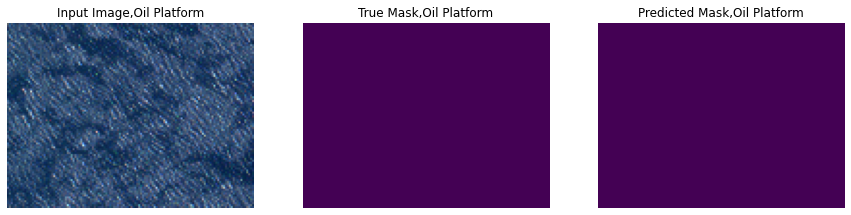

1/1 [==============================] - 0s 459ms/step
12


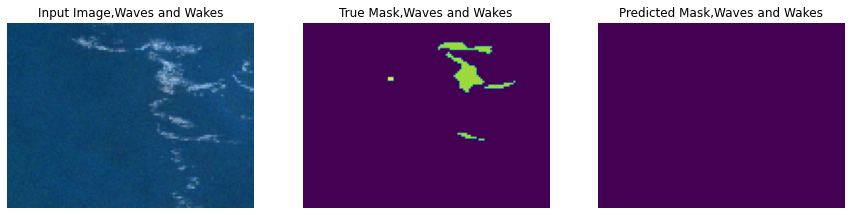

1/1 [==============================] - 0s 454ms/step
10


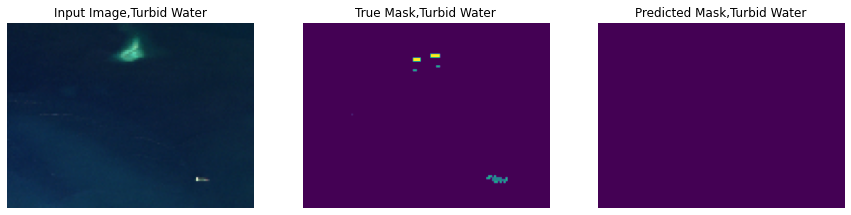

In [28]:
show_predictions(train_dataset, 6)